# Project \#4: Find the “Largest” Digit

# Part 3 : Kaggle Submission

In [2]:
RUN_NUM = 2

## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing

import keras.models
import keras.layers
import keras.optimizers
import keras.preprocessing
import keras.preprocessing.image
import keras.callbacks

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
import preprocessing as pre

In [5]:
# if change preprocessing file need to reload module here..
import imp
imp.reload(pre)

<module 'preprocessing' from 'preprocessing.pyc'>

## Read and Preprocess the Data

In [6]:
!ls

0_DataPreprocessing2.ipynb   2_Neural_Network.ipynb    preprocessing.py
0_DataPreprocessing.ipynb    3_KaggleSubmission.ipynb  preprocessing.pyc
1_BaseLineClassifiers.ipynb  Datasets		       submission1.csv


In [7]:
!ls ./Datasets

notebook.ipynb		  processed_train_x.csv.zip  tmp_x.csv
processed_sample_x.csv	  sample_x.csv		     train_x.csv
processed_test_x.csv	  sample_y.csv		     train_y.csv
processed_test_x.csv.zip  submission1.h5
processed_train_x.csv	  test_x.csv


In [8]:
!head -n 5000 Datasets/train_x.csv > Datasets/sample_x.csv
!head -n 5000 Datasets/train_y.csv > Datasets/sample_y.csv

In [9]:
TARGET_SHAPE = (25,25)

In [10]:
y = np.loadtxt("Datasets/train_y.csv", delimiter=",").reshape(-1, 1)

In [11]:
y = sklearn.preprocessing.OneHotEncoder().fit_transform(y).toarray()

In [12]:
#data = np.loadtxt('Datasets/train_x.csv', delimiter=",").reshape(-1, 25, 25)
data = np.loadtxt('Datasets/processed_train_x.csv', delimiter=",").reshape(-1, 25, 25)

## Preprocessing

In [13]:
def originalFlow(img, threshold=255, distance=4, shape=(28,28)):
    binImg = pre.toBinary(img, threshold)
    grps = pre.connectedCluster(binImg, distance)
    sliceBounds = pre.largestBounds([pre.getBounds(grp) for grp in grps])
    digit = pre.sliceImg(binImg, sliceBounds)
    return pre.scaledStretch(digit, shape)

In [14]:
def origWithSmoothing(img, **config):
    orig = originalFlow(img, **config)
    return pre.roundImageBin(orig, 3)

In [15]:
def betterRounding(img, **config):
    shape = config['shape']
    orig = originalFlow(img, **config)
    tmp = pre.scaledStretch(orig, (int(shape[0]*2), int(shape[1]*2)))
    tmp = pre.roundImageBin(tmp, 2)
    tmp = pre.getImgCenter(tmp, (int(shape[0]*2), int(shape[1]*2)))
    tmp = pre.scaledStretch(tmp, (int(shape[0]), int(shape[1])))
    return tmp

In [16]:
def sliceFromOrig(img, threshold=255, distance=4, shape=(28,28)):
    binImg = pre.toBinary(img, threshold)
    grps = pre.connectedCluster(binImg, distance)
    sliceBounds = pre.largestBounds([pre.getBounds(grp) for grp in grps])
    digit = pre.sliceImg(img, sliceBounds)
    return pre.scaledStretch(digit, shape)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


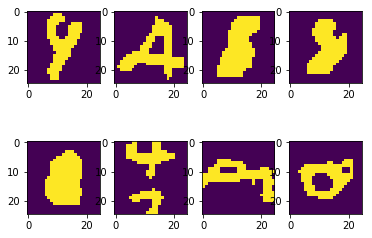

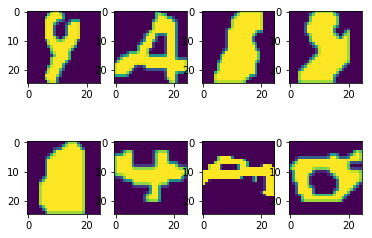

In [17]:
config = {'threshold':250, 'distance':2, 'shape':TARGET_SHAPE}
pre.displayImgs(data[[0,10,23,46,65,68,82,118]], n_cols=4)
pre.displayImgs([sliceFromOrig(d, **config) for d in data[[0,10,23,46,65,68,82,118]]], n_cols=4)

In [18]:
# processedData = [sliceFromOrig(d, **config) for d in data]
processedData = data

In [19]:
X_train = np.array(processedData[len(processedData)/5:])
Y_train = np.array(y[len(processedData)/5:])
X_val = np.array(processedData[:len(processedData)/5])
Y_val = np.array(y[:len(processedData)/5])

In [20]:
print 'X_train', X_train.shape
print 'Y_train', Y_train.shape
print 'X_val', X_val.shape
print 'Y_val', Y_val.shape

X_train (40000, 25, 25)
Y_train (40000, 10)
X_val (10000, 25, 25)
Y_val (10000, 10)


In [21]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

## Define the Model

In [22]:
from keras import backend as K
#refer to : https://github.com/keras-team/keras/issues/2681#issuecomment-257157218
K.set_image_dim_ordering('tf')

In [103]:
model = keras.models.Sequential()

input_shape=(TARGET_SHAPE[0],TARGET_SHAPE[1], 1)
model.add(keras.layers.Conv2D(32, nb_row=5, nb_col=5, border_mode='same', activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(32, nb_row=5, nb_col=5, border_mode='same', activation ='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))


model.add(keras.layers.Conv2D(64, nb_row=3, nb_col=3, border_mode='same', activation='relu'))
model.add(keras.layers.Conv2D(64, nb_row=3, nb_col=3, border_mode='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(keras.layers.Dropout(0.25))


model.add(keras.layers.Conv2D(28, nb_row=2, nb_col=2, border_mode='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(keras.layers.Dropout(0.1))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation = "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [104]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [25]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [105]:
epochs = 30
batch_size = 86

In [84]:
def scheduler(epoch):
    if epoch%3 == 0 and epoch!=0:
        model.optimizer.lr.set_value(model.optimizer.lr.get_value()/2.0)
    print 'current lr', model.optimizer.lr.get_value()
    return float(model.optimizer.lr.get_value())

change_lr = keras.callbacks.LearningRateScheduler(scheduler)

In [106]:
history = model.fit_generator(
    datagen.flow(X_train,Y_train, batch_size=batch_size), samples_per_epoch=X_train.shape[0],
#history = model.fit(
#    X_train,Y_train, batch_size=batch_size,
    nb_epoch=epochs,
    validation_data = (X_val, Y_val),
    verbose=2
    ,callbacks=[change_lr]
)

current lr 0.0010000000475
Epoch 1/30
32s - loss: 1.1214 - acc: 0.6469 - val_loss: 0.4969 - val_acc: 0.8677
current lr 0.0010000000475
Epoch 2/30
32s - loss: 0.6096 - acc: 0.8309 - val_loss: 0.5656 - val_acc: 0.8569
current lr 0.0010000000475
Epoch 3/30
32s - loss: 0.5273 - acc: 0.8546 - val_loss: 0.4203 - val_acc: 0.8889
current lr 0.000500000023749
Epoch 4/30
32s - loss: 0.4592 - acc: 0.8734 - val_loss: 0.3431 - val_acc: 0.9044
current lr 0.000500000023749
Epoch 5/30
32s - loss: 0.4331 - acc: 0.8797 - val_loss: 0.3528 - val_acc: 0.9044
current lr 0.000500000023749
Epoch 6/30
32s - loss: 0.4290 - acc: 0.8825 - val_loss: 0.3335 - val_acc: 0.9094
current lr 0.000250000011874
Epoch 7/30
32s - loss: 0.4038 - acc: 0.8886 - val_loss: 0.3178 - val_acc: 0.9136
current lr 0.000250000011874
Epoch 8/30
32s - loss: 0.3974 - acc: 0.8898 - val_loss: 0.3105 - val_acc: 0.9130
current lr 0.000250000011874
Epoch 9/30
32s - loss: 0.3931 - acc: 0.8936 - val_loss: 0.3053 - val_acc: 0.9170
current lr 0.000

In [108]:
model.save_weights('Datasets/submission'+str(RUN_NUM)+'.h5')

In [88]:
X_val_pred = model.predict(X_val)

In [94]:
X_val_noonehot = [np.argmax(a) for a in X_val_pred]
Y_val_noonehot = [np.argmax(a) for a in Y_val]
tmps = np.equal(X_val_noonehot, Y_val_noonehot)
inds = np.where(tmps == False)[0]

In [97]:
inds

array([  10,   46,   65,   68,   78,   79,   82,  118,  128,  174,  194,
        208,  213,  222,  226,  245,  284,  298,  305,  307,  322,  334,
        336,  349,  370,  384,  408,  409,  443,  453,  509,  513,  515,
        523,  529,  542,  546,  555,  561,  562,  570,  598,  606,  635,
        645,  669,  688,  693,  700,  715,  717,  722,  724,  725,  738,
        751,  765,  768,  781,  797,  808,  819,  820,  827,  835,  841,
        850,  868,  896,  897,  902,  904,  911,  926,  936,  940,  944,
        945,  956,  966,  968,  970,  982,  988, 1067, 1084, 1113, 1136,
       1146, 1150, 1164, 1169, 1195, 1202, 1204, 1212, 1214, 1233, 1255,
       1266, 1287, 1293, 1323, 1346, 1348, 1360, 1374, 1381, 1392, 1417,
       1432, 1437, 1452, 1464, 1466, 1467, 1471, 1487, 1488, 1492, 1496,
       1517, 1534, 1546, 1563, 1588, 1593, 1609, 1614, 1637, 1658, 1659,
       1679, 1684, 1733, 1736, 1741, 1781, 1808, 1812, 1813, 1843, 1854,
       1860, 1863, 1865, 1872, 1882, 1884, 1906, 19

(imageNum, prediction, actual)


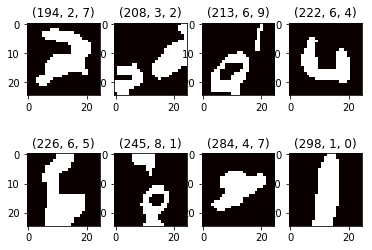

In [91]:
f, axarr = plt.subplots(2, 4)
f.subplots_adjust(hspace=0.5)
print '(imageNum, prediction, actual)'
axarr[0][0].set_title((inds[0][10], X_val_noonehot[inds[0][10]], Y_val_noonehot[inds[0][10]]))
axarr[0][0].imshow(X_val[inds[0][10]].reshape((25,25)), cmap='hot', interpolation='nearest')
axarr[0][1].set_title((inds[0][11], X_val_noonehot[inds[0][11]], Y_val_noonehot[inds[0][11]]))
axarr[0][1].imshow(X_val[inds[0][11]].reshape((25,25)), cmap='hot', interpolation='nearest')
axarr[0][2].set_title((inds[0][12], X_val_noonehot[inds[0][12]], Y_val_noonehot[inds[0][12]]))
axarr[0][2].imshow(X_val[inds[0][12]].reshape((25,25)), cmap='hot', interpolation='nearest')
axarr[0][3].set_title((inds[0][13], X_val_noonehot[inds[0][13]], Y_val_noonehot[inds[0][13]]))
axarr[0][3].imshow(X_val[inds[0][13]].reshape((25,25)), cmap='hot', interpolation='nearest')
axarr[1][0].set_title((inds[0][14], X_val_noonehot[inds[0][14]], Y_val_noonehot[inds[0][14]]))
axarr[1][0].imshow(X_val[inds[0][14]].reshape((25,25)), cmap='hot', interpolation='nearest')
axarr[1][1].set_title((inds[0][15], X_val_noonehot[inds[0][15]], Y_val_noonehot[inds[0][15]]))
axarr[1][1].imshow(X_val[inds[0][15]].reshape((25,25)), cmap='hot', interpolation='nearest')
axarr[1][2].set_title((inds[0][16], X_val_noonehot[inds[0][16]], Y_val_noonehot[inds[0][16]]))
axarr[1][2].imshow(X_val[inds[0][16]].reshape((25,25)), cmap='hot', interpolation='nearest')
axarr[1][3].set_title((inds[0][17], X_val_noonehot[inds[0][17]], Y_val_noonehot[inds[0][17]]))
axarr[1][3].imshow(X_val[inds[0][17]].reshape((25,25)), cmap='hot', interpolation='nearest')

In [102]:
??pre.displayImgs

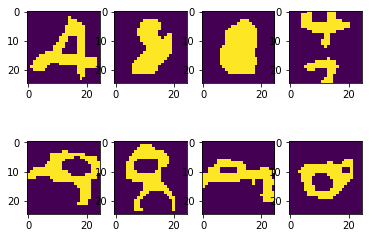

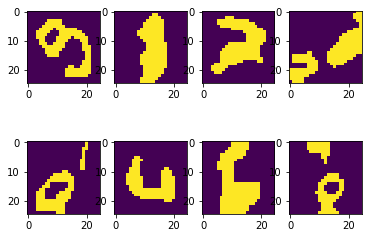

In [101]:
(inds[0][17], X_val_noonehot[inds[0][17]], Y_val_noonehot[inds[0][17]])
pre.displayImgs(X_val[inds[:8]].reshape(-1,25,25), titles=, n_cols=4)
pre.displayImgs(X_val[inds[8:16]].reshape(-1,25,25), n_cols=4)

## Making submission

In [109]:
!ls Datasets/

notebook.ipynb		  processed_train_x.csv.zip  test_x.csv
processed_sample_x.csv	  sample_x.csv		     tmp_x.csv
processed_test_x.csv	  sample_y.csv		     train_x.csv
processed_test_x.csv.zip  submission1.h5	     train_y.csv
processed_train_x.csv	  submission2.h5


In [110]:
X_test = np.loadtxt('Datasets/processed_test_x.csv', delimiter=",").reshape(-1, TARGET_SHAPE[0], TARGET_SHAPE[1])

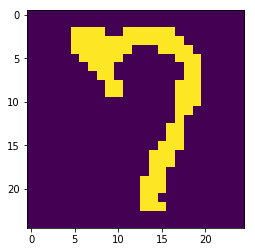

In [112]:
plt.imshow(X_test[0])

In [113]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [114]:
X_test_pred = model.predict(X_test)

In [115]:
X_test_pred.shape

(10000, 10)

In [116]:
X_test_noonehot = [np.argmax(a) for a in X_test_pred]

In [117]:
len(X_test_noonehot)

10000

In [118]:
csvData = {'Label' : X_test_noonehot}
df = pd.DataFrame(data=csvData)

In [119]:
df

,Label
0,7
1,2
2,0
3,7
4,6
5,1
6,5
7,3
8,8
9,1


In [120]:
df.to_csv('submission'+str(RUN_NUM)+'.csv', index_label='Id')

In [124]:
!head submission2.csv

Id,Label
0,7
1,2
2,0
3,7
4,6
5,1
6,5
7,3
8,8
